## Exercise 4
### 1)

In [1]:
import pandas as pd
import numpy as np
from icecream import ic

# Running it 10 times
res = []
for _ in range(100):

    m = 10
    mean_service_time = 8
    mean_time_btw_customers = 1

    cum_cust = 0
    cum_time = 0
    blocked = []
    n_customer = 10_000
    service = []


    def update_service_time(service, time):
        # update the time
        for i in range(len(service)):
            service[i] = service[i] - time

    def remove_serviced(service, t):
        # remove the ones which are below a threshold
        new_service = []
        for i in range(len(service)):
            if service[i] > t:
                new_service.append(service[i])
        return new_service


    for id in range(n_customer):
        time = np.random.exponential(mean_time_btw_customers) 

        # remove the time drawn from the customers "in service" time
        update_service_time(service, time)
        service = remove_serviced(service, 0) # remove the customers with 0 or below time

        cum_cust += 1
        cum_time += time
        if len(service) < m:
            service_time = np.random.exponential(mean_service_time, 1)[0] 
            service.append(service_time)
        else:
            blocked.append(id)
    res.append(len(blocked) / n_customer)

In [2]:
import math
import scipy
# The mean is:

def var_mean(res):
    mean = np.mean(np.array(res))
    var = abs((1/(n_customer -1))  * sum([(x**2)- mean**2 for x in res]))
    first = ((math.sqrt(var))  /  math.sqrt(n_customer))  
    second = scipy.stats.t.ppf(0.025, df = (n_customer-1)) 
    third = scipy.stats.t.ppf(1-0.025, df = (n_customer-1)) 
    ic(mean + first*second)
    ic(mean)
    ic(mean + first*third)
var_mean(res)

ic| mean + first*second: 0.12252503631687924
ic| mean: 0.12253599999999999
ic| mean + first*third: 0.12254696368312075


In [3]:
# Calculating theoretical
import math

l = mean_time_btw_customers
s = mean_service_time
A =  l * s

upp = ((A**m)/math.factorial(m)) 
lowr = [(A**i)/math.factorial(i) for i in range(m + 1)]
lowr = sum(lowr)
upp/lowr

0.12166106425295149

We have nearly the same values between the theroretical and our simulated 

### 2)

In [4]:
import pandas as pd
import numpy as np
from icecream import ic
from functools import partial
# The same algorithm as above 
def algo(func1):
    m = 10
    mean_service_time = 8
    mean_time_btw_customers = 1

    cum_cust = 0
    cum_time = 0
    blocked = []
    n_customer = 10_000
    service = []


    for id in range(n_customer):
        time = func1()

        # remove the time drawn from the customers "in service" time
        update_service_time(service, time)
        service = remove_serviced(service, 0) # remove the customers with 0 or below time

        cum_cust += 1
        cum_time += time
        if len(service) < m:
            service_time = np.random.exponential(mean_service_time, 1)[0] 
            service.append(service_time)
        else:
            blocked.append(id)

    return (len(blocked) / n_customer)

res = []
for _ in range(11):
    out = algo(partial(scipy.stats.erlang.rvs, a=1))
    res.append(out)
var_mean(res)

ic| mean + first*second: 0.11995129568701861
ic| mean: 0.11995454545454544
ic| mean + first*third: 0.11995779522207227


In [5]:
def hyper_exp():
    p = 0.8
    rand = np.random.uniform() 
    if rand  < p:
        return np.random.exponential(1/0.8333, 1)[0] 
    else: 
        return np.random.exponential(1/5.0, 1)[0] 

res = []
for _ in range(11):
    out = algo(hyper_exp)
    res.append(out)
var_mean(res)

ic| mean + first*second: 0.14040395249728033
ic| mean: 0.1404090909090909
ic| mean + first*third: 0.14041422932090147


# Etc
# Not needed
start = 0
end = 1
u_in_range = np.logical_and(u > start, u < end)
x = x[u_in_range]
u = u[u_in_range]

# 5

In [16]:
import numpy as np
from icecream import ic
import scipy
import math
import seaborn as sns

# 1 Crude
u = np.random.uniform(size=100)
x = np.exp(u)

# Def print mu,std and interval
def print_stats(x):
    mu = np.mean(x)
    std = np.std(x)
    interval = scipy.stats.norm.interval(0.05, loc=mu, scale=std)
    ic(mu, std**2, interval)

print_stats(x)
# Both the theoretical mean (1.72) and variance
# Are close to ones we found (above)

ic| mu: 1.6526825515356363
    std**2: 0.23988050092545424
    interval: (1.6219702785342172, 1.6833948245370554)


In [18]:
# 2 Antithetic variables
u = np.random.uniform(size=100)
y = (np.exp(u) + np.exp(1-u)) / 2
print_stats(y)
# This time the variance is smaller. As expected

ic| mu: 1.709174439378761
    std**2: 0.0034457633983818892
    interval: (1.7054935123094779, 1.712855366448044)


In [83]:
# 3 Control variable
u = np.random.uniform(size=100)
x = np.exp(u) 

COV = 0.14086 # From slides
C = - COV / np.var(u) 
z = x + C * (u - 1/2)

print_stats(z)
# Again we get a lower estimate than using
# the crude method

ic| mu: 1.7223616570431395
    std**2: 0.008198704559389381
    interval: (1.7166837653440739, 1.7280395487422051)


In [248]:
# 4 Stratified sampling
u = np.random.uniform(size=100)

n = 10
u_splits = np.split(u, n)

sum = 0
for i, split in enumerate(u_splits):
    sum += np.exp(u/n + i/n) 

w = sum / n
print_stats(w)
# Again we get simmilar results

ic| mu: 1.7200248007053325
    std**2: 0.002690263402383624
    interval: (1.7167723412766691, 1.7232772601339958)


In [8]:
#5  Use control variates to reduce the variance of the estimator in E4

from functools import partial

def update_service_time(service, time):
    # update the time
    for i in range(len(service)):
        service[i] = service[i] - time

def remove_serviced(service, t):
    # remove the ones which are below a threshold
    new_service = []
    for i in range(len(service)):
        if service[i] > t:
            new_service.append(service[i])
    return new_service

# The same algorithm as above 
def algo(func1):
    m = 10
    mean_service_time = 8
    mean_time_btw_customers = 1

    cum_cust = 0
    cum_time = 0
    blocked = []
    n_customer = 10_000
    service = []


    for id in range(n_customer):
        time = func1()

        # remove the time drawn from the customers "in service" time
        update_service_time(service, time)
        service = remove_serviced(service, 0) # remove the customers with 0 or below time

        cum_cust += 1
        cum_time += time
        if len(service) < m:
            service_time = np.random.exponential(mean_service_time, 1)[0] 
            service.append(service_time)
        else:
            blocked.append(id)

    return (len(blocked) / n_customer)



# Without control variance estimation
res = []
for _ in range(11):
    out = algo(partial(np.random.exponential, 1))
    res.append(out)
var_mean(res)


ic| mean + first*second: 0.11990578951197833
ic| mean: 0.11990909090909091
ic| mean + first*third: 0.11991239230620349


In [127]:

def sample_exp_control_variates():
    size = 10_000
    u = np.random.uniform(size=size)
    x = np.exp(u) 
    COV = 0.14086 # From slides
    C = - COV / np.var(u) 
    z = x + C * (u - 1/2)
    for i in range(size):
        yield z[i]

# With control variance estimation
res = []
for _ in range(11):
    sampler = sample_exp_control_variates()
    out = algo(lambda : next(sampler))
    res.append(out)
var_mean(res)
# Get a wrong result


ic| mean + first*second: 0.000463441764602777
ic| mean: 0.00046363636363636366
ic| mean + first*third: 0.0004638309626699503


<Axes: >

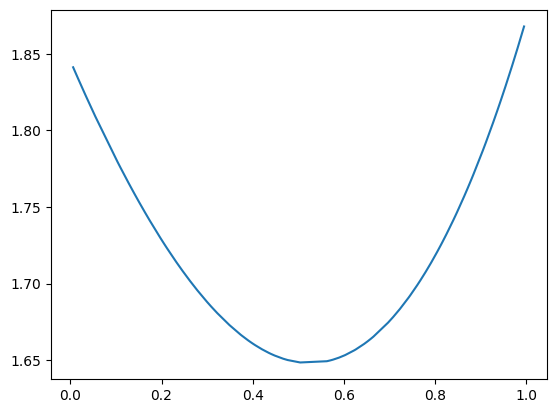

In [129]:
# Plot also seem off.
def sample_exp_control_variates():
    size = 10_000
    u = np.random.uniform(size=size)
    x = np.exp(-u) # TODO minus here 
    COV = 0.14086 # From slides
    C = - COV / np.var(u) 
    z = x + C * (u - 1/2)
    for i in range(size):
        yield u[i], z[i]

sampler = sample_exp_control_variates()
samp = lambda : next(sampler)
a = []
b = []
for _ in range(100):
    x, y = samp()
    a.append(x)
    b.append(y)
a = np.array(a)
import seaborn as sns
sns.lineplot(x=a, y=b)

# Day 6
#### E1

<Axes: >

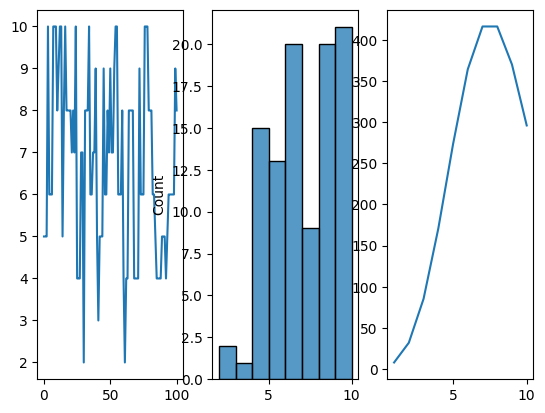

In [574]:
%reset -f
import numpy as np, scipy, math, seaborn as sns
import matplotlib.pyplot as plt
from icecream import ic
# Setting the parameters from E4
mean_service_time = 8
mean_time_btw_customers = 1
l = mean_time_btw_customers
s = mean_service_time
A =  l * s
m = 10

# The funciton to simulate
g = lambda i: (A**i)/ math.factorial(i)

x_old = 5 # initial value
x_list = [x_old]
i_list = [0]

n = 100
for i in range(1, n+1):
    x_new = np.random.randint(low=1, high=m+1)
    a = g(x_new)/g(x_old)
    u = np.random.uniform()
    # Accepting or rejecting the new value
    if u <= a:
        x_old = x_new
    x_list.append(x_old)
    i_list.append(i)

fig, ax = plt.subplots(1,3)
sns.lineplot(x=i_list, y=x_list, ax=ax[0])
sns.histplot(x_list, ax=ax[1])

# Plotting the values to see the distribution
i = np.arange(1,m+1)
y = (A**i)/ np.array(list(map(math.factorial, i)))
sns.lineplot(x=i, y=y, ax=ax[2])

# Below we can see the distribution we simulated 
# is matching the distribution we tried to simulate

In [575]:
# testing the dist with chi-square test
# Binning the distribution
random_numbers = x_list
(bins, binby) = np.histogram(random_numbers, bins=list(range(0, m+1)))

# The ideal numbers to compare against
bins_ideal = y/(sum(y)) # expected percent values
bins = bins/sum(bins)

# Calculate test-statistic
sum = 0
for observed, expected in zip(bins, bins_ideal):
    sum += (observed - expected)**2 /  \
        expected
T = sum
ic(T)
ic(len(bins_ideal))
ic(len(bins))


# Testing
m = 0
df = len(bins) - 1 - m 
ic(1 - scipy.stats.chi2.cdf(x = T, df = df))

# Based on this the two distributions are equal (p=0.999)

ic| T: 0.20798485877522002
ic| len(bins_ideal): 10
ic| len(bins): 10
ic| 1 - scipy.stats.chi2.cdf(x = T, df = df): 0.999999338159666


0.999999338159666

#### E2

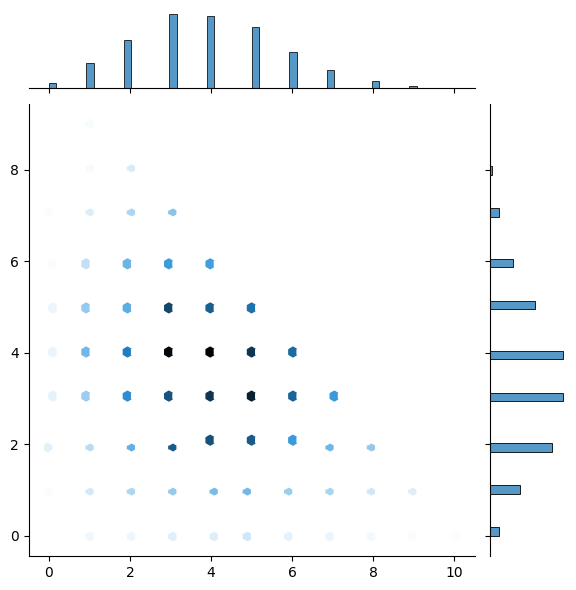

In [576]:

%reset -f
import numpy as np, scipy, math, seaborn as sns
import matplotlib.pyplot as plt
from icecream import ic
# Setting the parameters from E4
A =  4
m = 10

# The funciton to simulate
# In this case it takes two values instead of one
g = lambda i,j : ((A**i)/ math.factorial(i)) * ((A**j)/ math.factorial(j))

x_old = [1,2] # initial value
x_list1 = [x_old[0]]
x_list2 = [x_old[1]]
i_list = [0]

n = 10_000
for i in range(1, n+1):
    x_new = [np.nan,np.nan]
    x_new[0] = np.random.randint(size=1, low=0, high=m+1)[0]
    x_new[1] = np.random.randint(size=1, low=0, high=m+1-x_new[0])[0]

    a = g(x_new[0], x_new[1])/g(x_old[0], x_old[1])
    u = np.random.uniform()
    # Accepting or rejecting the new value
    if u <= a:
        x_old = x_new
    x_list1.append(x_old[0])
    x_list2.append(x_old[1])
    i_list.append(i)

# Plotting the distribution
sns.jointplot(x=x_list1, y=x_list2, kind="hex")
# In this case we can see the values in 2d.
# And we can see that the methods works with
# several values

ic| np.meshgrid(x,x): [array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
                             [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
                             [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
                             [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
                             [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
                             [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
                             [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
                             [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
                             [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
                             [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
                             [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]]),
                       array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
                             [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
                     

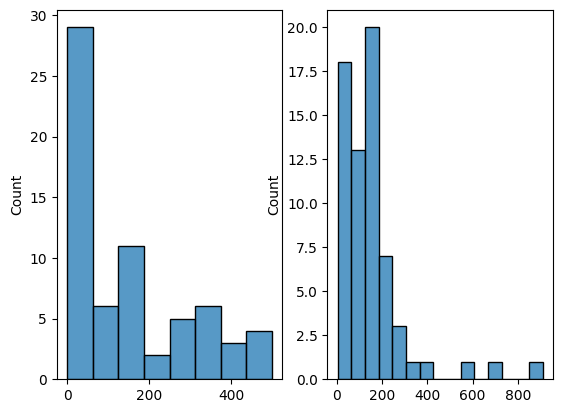

In [610]:
from scipy.stats import chisquare
# defining method to test distributions with two variables
def test_two_chi2(x_arr, y_arr, g):
    def count_target(x_arr, y_arr, x_target, y_target):
        # Count the numbers which match the target
        count = 0
        for x, y in zip(x_arr, y_arr):
            if x == x_target and y == y_target:
                count += 1
        return count

    # Calculate expected for each combination and the found
    x = np.arange(0, 10+1)
    first, second = ic(np.meshgrid(x,x))
    expected = []
    target = []
    for f,s in zip(first.flatten(), second.flatten()):
        if f + s <= 10: 
            expected.append(g(f,s))
            target.append(count_target(x_arr, y_arr, f, s))

    expected = np.array(expected)
    target = np.array(target)
    import matplotlib.pyplot as plt
    plt,ax = plt.subplots(1,2)

    # Converting to propabilities
    expected = (expected/sum(expected)) * sum(target)
    sns.histplot(target, ax=ax[0])
    sns.histplot(expected,ax=ax[1])

    # Calculating the statistic
    total = 0
    for observed, expec in zip(target, expected):
        total += (observed - expec)**2 /  \
            expec
    T = total

    # And testing the statistic
    m = 0
    df = len(target) - 1 - m  

    ic(1 - scipy.stats.chi2.cdf(x = T, df = df), T)

# Testing the distribution fit 
x_arr = np.array(x_list1)
y_arr = np.array(x_list2)
test_two_chi2(x_arr, y_arr, g)
# As can be seen it seems to not follow the distribution
# Meaning that we might have made a mistake somewhere 


b)

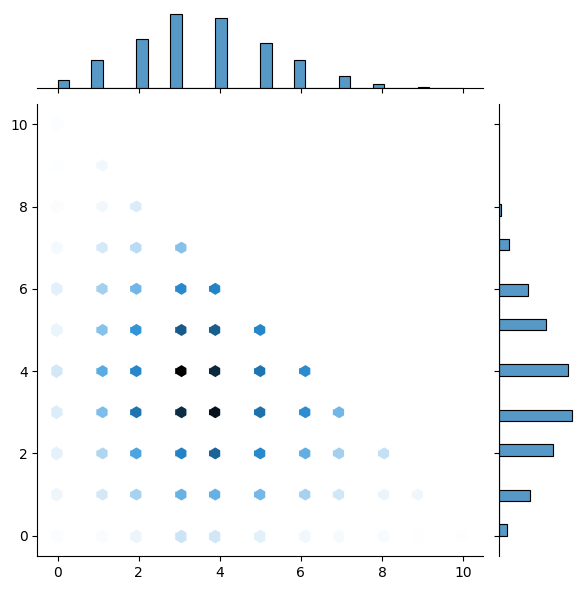

In [596]:
## Coordinatewise implementation
# It swaps between each coordinate on each
# iteration

import numpy as np, scipy, math, seaborn as sns
import matplotlib.pyplot as plt
from icecream import ic
# Setting the parameters from E4
A =  4
m = 10

# The funciton to simulate
# In this case it takes two values instead of one, as  before
g = lambda i,j : ((A**i)/ math.factorial(i)) * ((A**j)/ math.factorial(j))

# initial values
x_old = [1,2] # initial value
x_list1 = [x_old[0]]
x_list2 = [x_old[1]]
i_list = [0]

left_direction = False

n = 10
n = 10_000
for i in range(1, n+1):

    # Only take a step in either direction
    # Implemented by keeping either old value:
    if left_direction:
        # Only generate one random number
        x_new = np.random.randint(size=1, low=0, high=m+1-x_old[1])
        x_new = x_new[0]
        x_new = [x_new, x_old[1]]
        left_direction = False
    else: 
        # Only generate one random number
        x_new = np.random.randint(size=1, low=0, high=m+1-x_old[0])
        x_new = x_new[0]
        x_new = [x_old[0], x_new]
        left_direction = True
    a = g(x_new[0], x_new[1])/g(x_old[0], x_old[1])

    u = np.random.uniform()
    # Accepting or rejecting the new value
    if u <= a:
        x_old = x_new
    x_list1.append(x_old[0])
    x_list2.append(x_old[1])
    i_list.append(i)

# Plotting the distribution
sns.jointplot(x=x_list1, y=x_list2, kind="hex")

# In this case the results seems simmilar as above
# Although this time we only need to draw 1 new random number
# As the possible candidate instead of 2 as in the previous method.
# The method is therefore less computational intensive! 

In [597]:
# Testing the distribution fit 
x_arr = np.array(x_list1)
y_arr = np.array(x_list2)
test_two_chi2(x_arr, y_arr, g)
# As can be seen it seems to not follow the distribution
# Meaning that we might have made a mistake somewhere again
# Posible with the chi2 implementation

ic| 1 - scipy.stats.chi2.cdf(x = T, df = df): 1.7852386235972517e-13
    T: 149.8978872529107


c) Gibbs sampling


Firstly we need to find the conditionaly distributions $P(i|j)$ and $P(j|i)$: \
Here finding $P(i|j)$ is sufficient as $P(j|i)$ will be the same with j and i swapped:
$$
P(i|j) = \frac{P(i,j)}{P(j)} = \frac{ c \cdot \frac{A_1^i}{i!} \frac{A_2^j}{j!}  } 
{\sum_{k=0}^{m-j} c \cdot \frac{A_1^k}{k!} \frac{A_2^j}{j!}   }
= 
\frac{ \frac{A_1^i}{i!} \frac{A_2^j}{j!}  } 
{\frac{A_1^j}{j!} \sum_{k=0}^{m-j}  \frac{A_1^k}{k!}   }
=
\frac{ \frac{A_2^i}{i!}  } 
{\sum_{k=0}^{m-j}  \frac{A_1^k}{k!}   }
$$




In [598]:
import numpy as np, scipy, math, seaborn as sns
import matplotlib.pyplot as plt
from icecream import ic
# Setting the parameters from E4
A =  4
m = 10

# The conditional distribution p(i|j) implemented as g(), as described above 
# (and p(j|i) implemented when given the arguments in the reverse order)
f = lambda i: ((A**i)/ math.factorial(i))
def g(i, j):
    out = f(i) / sum([f(k) for k in list(range(m+1-j))])
    return out


# Now define a function to sample from the conditional distribution
def sample_g(j):
    x = list(range(0, 11-j))
    y = np.array([g(i,j) for i in x])
    out = np.random.choice(x, p=y/(sum(y)))
    return out


ic| 1 - scipy.stats.chi2.cdf(x = T, df = df): 0.0
    T: 5212.608658545713


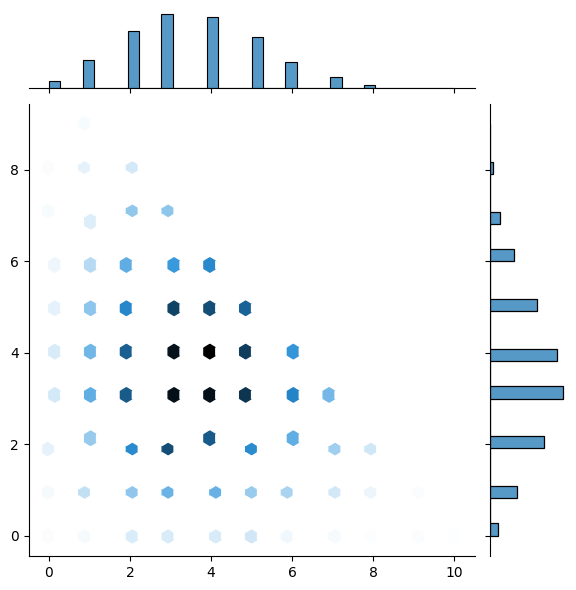

In [599]:
# Initial values
i = 4
j = 2
x_list1 = [i]
x_list2 = [j]
i_list = [0]

n = 10_000
for step in range(1, n+1):

    # Sample p(j|i)
    j = sample_g(i)

    # Sample p(i|j)
    i = sample_g(j)

    x_list1.append(i)
    x_list2.append(j)
    i_list.append(step)


# Plotting the distribution
sns.jointplot(x=x_list1, y=x_list2, kind="hex")
# Testing the distribution fit 
x_arr = np.array(x_list1)
y_arr = np.array(x_list2)
test_two_chi2(x_arr, y_arr, g)
# Again it seems to not follow the prober distribution :/